In [3]:
import torch.nn as nn
import torch, gzip, pickle
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib as mpl
from datasets import load_dataset

mpl.rcParams['image.cmap'] = 'gray'

In [4]:
with gzip.open('./data/mnist.pkl.gz', 'rb') as f:
    data = pickle.load(f, encoding='latin')

In [5]:
((x_train, y_train),(x_val, y_val), _) = data
(x_train, y_train, x_val, y_val) = map(torch.tensor, (x_train, y_train, x_val, y_val))

In [8]:
x_imgs = x_train.view(-1, 28, 28)
xval_imgs = x_val.view(-1, 28, 28)

label:3


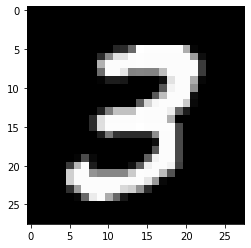

In [16]:
im3  = x_imgs[7]
plt.imshow(im3); print(f'label:{y_train[7]}')

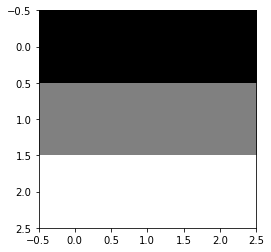

In [17]:
top_edges = torch.tensor([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1]
]).float()

plt.imshow(top_edges)

In [26]:
import pandas as pd

In [39]:
df = pd.DataFrame(im3[:13, :27])
df.style.background_gradient(cmap='PuBu').set_properties(**{'font-size': '7pt'})

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.148438,0.167969,0.410156,0.996094,0.988281,0.988281,0.988281,0.988281,0.988281,0.679688,0.023438,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.167969,0.542969,0.875000,0.882812,0.984375,0.988281,0.984375,0.984375,0.984375,0.984375,0.984375,0.984375,0.617188,0.054688,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.695312,0.984375,0.984375,0.984375,0.984375,0.988281,0.984375,0.984375,0.984375,0.984375,0.984375,0.984375,0.984375,0.230469,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.425781,0.984375,0.984375,0.898438,0.515625,0.519531,0.515625,0.515625,0.738281,0.984375,0.984375,0.984375,0.984375,0.230469,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015625,0.113281,0.113281,0.093750,0.000000,0.000000,0.000000,0.000000,0.054688,0.882812,0.984375,0.984375,0.671875,0.027344,0.000000,0.000000,0.000000,0.000000


In [71]:
t1 = (top_edges * im3[3:6, 14:17]).sum()
t1

tensor(2.9727)

In [72]:
def apply_kernel(row, col, kernel):
    return (im3[row-1:row+2, col-1:col+2]*kernel).sum()

In [73]:
t2 = apply_kernel(4, 15, top_edges)
t2

tensor(2.9727)

In [74]:
rng = range(1, 5)
[[(i, j) for j in rng] for i in rng]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

In [75]:
rng = range(1, 27)

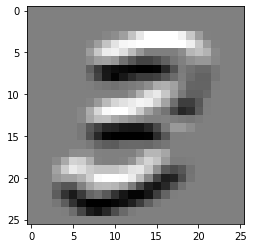

In [76]:
top_edge3 = [[apply_kernel(i, j, top_edges) for j in rng] for i in rng]
plt.imshow(top_edge3)

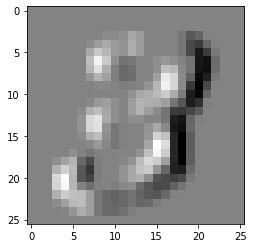

In [77]:
left_edges = torch.tensor([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
]).float()
left_edge3 = [[apply_kernel(i, j, left_edges) for j in rng] for i in rng]
plt.imshow(left_edge3)

In [119]:
inp = im3[None,None,:,:].float()
inp_unf = F.unfold(inp, (3,3))[0]

In [120]:
inp.shape

torch.Size([1, 1, 28, 28])

In [121]:
inp_unf.shape

torch.Size([9, 676])

In [122]:
w = left_edges.view(-1)
w.shape

torch.Size([9])

In [123]:
out_unf = w@inp_unf

In [124]:
out_unf.shape

torch.Size([676])

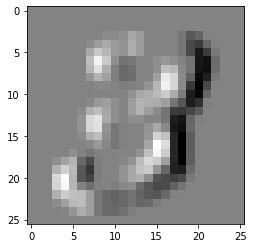

In [125]:
plt.imshow(out_unf.view(26, 26))

In [127]:
%timeit -n 1 [[apply_kernel(i, j, left_edges) for j in rng] for i in rng]

13.3 ms ± 6.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [129]:
%timeit -n 100 (w@F.unfold(inp, (3,3)))

88.5 µs ± 27.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [131]:
%timeit -n 100 F.conv2d(inp, top_edges[None,None])

The slowest run took 7.82 times longer than the fastest. This could mean that an intermediate result is being cached.
87.1 µs ± 99.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [132]:
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2)
    if act:
        res = nn.Sequential(res, nn.ReLU())
    return res

In [134]:
def get_simple_cnn():
    return nn.Sequential(
        *[
            conv(1, 4),
            conv(4, 8),
            conv(8, 16),
            conv(16, 32),
            conv(16, 16),
            conv(16, 10, act=False),
            nn.Flatten()
        ]
    )

In [135]:
simple_cnn = get_simple_cnn()

In [138]:
simple_cnn[0][0]

Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [140]:
simple_cnn[0][0].weight.shape

torch.Size([4, 1, 3, 3])

In [142]:
simple_cnn[0][0].bias.shape

torch.Size([4])

In [160]:
round(1.2)

1